In [23]:
%reload_ext autoreload
%autoreload 2

In [24]:
import os
import pandas as pd 
import wandb
import yaml
import numpy as np
import seaborn as sns
from tqdm import tqdm
from functools import cache
from matplotlib.ticker import ScalarFormatter

palette = sns.color_palette('Set2', 4)
sns.set(context='paper', 
        style='ticks', 
        palette=palette,
        font='Linux Libertine O', 
        font_scale=2.5, 
        rc={
            'mathtext.fontset': 'stix',
            'lines.linewidth' : 4,
            'lines.markersize' : 12,
        }
)
sns.despine()
os.makedirs('figs', exist_ok=True)

<Figure size 640x480 with 0 Axes>

In [15]:
with open('config/wandb.yaml') as f:
    wandb_config = yaml.safe_load(f)

api = wandb.Api()
runs = api.runs(f"{wandb_config['entity']}/{wandb_config['project']}", per_page=2000)

i = 0
data_list = []

for run in tqdm(runs): 
    data = {}
    data.update(run.summary._json_dict)
    data.update(run.config)
    data['id'] = i
    data['run'] = run
    data['method'] = data['method'].upper().replace('PRO', 'Pro')
    data_list.append(data)
    i += 1


100%|██████████| 3460/3460 [00:01<00:00, 1761.77it/s]


# Dataset Statistics

In [ ]:
from core.datasets.loader import DatasetLoader
from core.data.utils import num_edges

@cache
def load_dataset(dataset_name: str):
    data = DatasetLoader(dataset_name).load(verbose=False)
    return data

In [27]:
datasets = ['facebook', 'reddit', 'amazon', 'facebook-100', 'wenet']
records = []

for dataset in tqdm(datasets, desc='loading datasets'):
    data = load_dataset(dataset)
    nodes_degree = data.adj_t.to_sparse_coo().sum(dim=1).to_dense() # in degree
    records.append({
        'dataset': dataset,
        'nodes': data.num_nodes,
        'edges': num_edges(data),
        'features': data.num_features,
        'classes': int(data.y.max() + 1),
        'median degree': int(nodes_degree.median()),
    })

df = pd.DataFrame(records)
# df.sort_values('nodes', inplace=True)
df = df.applymap(lambda x: f'{x:,}' if isinstance(x, int) else x)
# print(df.to_latex(index=False))
df

loading datasets: 100%|██████████| 5/5 [00:07<00:00,  1.43s/it]


,dataset,nodes,edges,features,classes,median degree
0,facebook,"26,406","2,117,924",501,6,62
1,reddit,"116,713","46,233,380",602,8,209
2,amazon,"1,790,731","80,966,832",100,10,22
3,facebook-100,"1,120,280","86,304,478",537,6,57
4,wenet,"37,576","22,684,206",44,4,286


# Trade-offs between Privacy and Accuracy

### Main results

In [17]:
cols = ['id', 'method', 'level', 'dataset', 'epsilon', 'layerwise', 'repeats', 'train/acc_mean', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci', 'run']
methods = ['ProGAP', 'GAP']
datasets = ['facebook', 'reddit', 'amazon', 'facebook-100', 'wenet']

df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df.query('dataset in @datasets and method in @methods')
df.loc[df['level'] == 'none', 'epsilon'] = np.inf
df = df.query('level != "edge" or epsilon == 1')
df = df.query('level != "node" or epsilon == 8')
df = df.query('not method.str.startswith("ProGAP") or layerwise == False')
df = df.query('repeats == 10')

idx = df.groupby(['dataset', 'method', 'level', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df['acc'] = df[['test/acc_mean', 'test/acc_ci']].apply(
    lambda row: '%.1f $\pm$ %.2f' % (row['test/acc_mean'], row['test/acc_ci']), axis=1
)
df = df.drop(columns=['id', 'train/acc_mean', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci', 'layerwise'])

def sort_key(row):
    keys = {
        **{k:v+1 for v,k in enumerate(datasets)},       # datasets
        'ProGAP': 1, 'GAP': 2,                          # methods
        'none': 1, 'edge': 2, 'node': 3,                # levels
    }
    if isinstance(row, pd.Index):
        s = row.to_series()
        s = s.replace(keys)
        return pd.Index(s)
    else:
        return row.replace(keys)

df = df.sort_values(by=['dataset', 'level', 'method'], key=sort_key)
pd.options.display.width = 1000
pd.options.display.max_colwidth = 1000
df['run'] = df['run'].apply(lambda x: x.url)
# print(df.query('method.str.startswith("ProGAP")').drop(columns=['dp_level', 'acc']))
df = df.pivot(columns='dataset', index=['level', 'method', 'epsilon'], values='acc')
df = df.reset_index().sort_values(
    by=['level', 'method'],
    key=sort_key
).set_index(['level', 'method', 'epsilon'])
df = df.sort_index(axis=1, key=sort_key)
df = df.rename(str.title, axis=1)
df = df.rename(str.title, axis=0, level=0)
df = df.rename_axis(index={'level': 'Privacy Level', 'epsilon': 'privacy cost'})
df = df.rename_axis(index=str.title)
df = df.rename_axis(columns=str.title)
# print(df.style.to_latex())
df

               method       dataset  epsilon  repeats                                            run
1753  ProGAP-$\infty$      facebook      inf       10  https://wandb.ai/sisaman/ProGAP/runs/uitxzc6n
1090       ProGAP-EDP      facebook      1.0       10  https://wandb.ai/sisaman/ProGAP/runs/dutumrwa
1664       ProGAP-NDP      facebook      8.0       10  https://wandb.ai/sisaman/ProGAP/runs/ural1ydj
1589  ProGAP-$\infty$        reddit      inf       10  https://wandb.ai/sisaman/ProGAP/runs/dh5l7we1
1525       ProGAP-EDP        reddit      1.0       10  https://wandb.ai/sisaman/ProGAP/runs/nf55n252
1394       ProGAP-NDP        reddit      8.0       10  https://wandb.ai/sisaman/ProGAP/runs/ao5g2n7a
1269  ProGAP-$\infty$        amazon      inf       10  https://wandb.ai/sisaman/ProGAP/runs/8qitab09
1205       ProGAP-EDP        amazon      1.0       10  https://wandb.ai/sisaman/ProGAP/runs/fhj0nlst
991        ProGAP-NDP        amazon      8.0       10  https://wandb.ai/sisaman/ProGAP/runs

Dataset                                            Facebook           Reddit           Amazon     Facebook-100            Wenet
Privacy Level Method          Privacy Cost                                                                                     
None          ProGAP-$\infty$ $\infty$      84.5 $\pm$ 0.24  99.3 $\pm$ 0.03  93.3 $\pm$ 0.04  74.4 $\pm$ 0.14  73.9 $\pm$ 0.25
              GAP-$\infty$    $\infty$      80.5 $\pm$ 0.42  99.5 $\pm$ 0.01  92.0 $\pm$ 0.10  66.4 $\pm$ 0.35  69.7 $\pm$ 0.14
Edge          ProGAP-EDP      1.0           77.2 $\pm$ 0.33  97.8 $\pm$ 0.05  84.2 $\pm$ 0.07  56.9 $\pm$ 0.30  68.8 $\pm$ 0.23
              GAP-EDP         1.0           69.4 $\pm$ 0.39  97.5 $\pm$ 0.06  78.8 $\pm$ 0.26  46.5 $\pm$ 0.58  62.4 $\pm$ 0.28
Node          ProGAP-NDP      8.0           69.3 $\pm$ 0.33  94.0 $\pm$ 0.04  79.1 $\pm$ 0.10  48.5 $\pm$ 0.36  61.0 $\pm$ 0.34
              GAP-NDP         8.0           63.9 $\pm$ 0.49  93.9 $\pm$ 0.09  77.6 $\pm$ 0.07  43.0 $\pm$ 0.20  58.2 $\pm$ 0.39

# Progressive vs. Layerwise

In [18]:
cols = ['id', 'method', 'level', 'dataset', 'epsilon', 'layerwise', 'repeats', 'train/acc_mean', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci']
methods = ['ProGAP', 'GAP']
datasets = ['facebook', 'reddit', 'amazon', 'facebook-100', 'wenet']

df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df.query('dataset in @datasets and method in @methods')
df.loc[df['level'] == 'none', 'epsilon'] = np.inf
df = df.query('level != "edge" or epsilon == 1')
df = df.query('level != "node" or epsilon == 8')
df = df.query('repeats == 10')

idx = df.groupby(['dataset', 'method', 'level', 'epsilon', 'layerwise'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df['acc'] = df[['test/acc_mean', 'test/acc_ci']].apply(
    lambda row: '%.1f $\pm$ %.2f' % (row['test/acc_mean'], row['test/acc_ci']), axis=1
)
df = df.drop(columns=['id', 'train/acc_mean', 'val/acc_mean', 'test/acc_mean', 'test/acc_ci'])

def sort_key(row):
    keys = {
        **{k:v+1 for v,k in enumerate(datasets)},     # datasets
        'None-Private': 1, 'Edge-Level': 3, 'Node-Level': 6,  # methods
        'Progressive': 1, 'Layerwise': 2,  # layerwise
    }
    if isinstance(row, pd.Index):
        s = row.to_series()
        s = s.replace(keys)
        return pd.Index(s)
    else:
        return row.replace(keys)

df = df.sort_values(by=['dataset', 'method', 'layerwise'], key=sort_key)
df['Privacy Level'] = df['level'].apply(lambda x: {'none': 'Non-Private', 'edge': 'Edge-Level', 'node': 'Node-Level'}[x])
df['Approach'] = df['layerwise'].apply(lambda x: 'Layerwise' if x else 'Progressive')
df = df.drop(columns=['method', 'layerwise', 'level'])
df = df.pivot(columns='dataset', index=['Privacy Level', 'epsilon', 'Approach'], values='acc')
df = df.reset_index().sort_values(
    by=['Privacy Level', 'Approach'],
    key=sort_key
).set_index(['Privacy Level', 'epsilon', 'Approach'])
df = df.sort_index(axis=1, key=sort_key)
df = df.rename(str.title, axis=1)
df = df.rename(str.title, axis=0, level=0)
df = df.rename_axis(index={'epsilon': 'privacy cost'})
df = df.rename_axis(index=str.title)
df = df.rename_axis(columns=str.title)
# print(df.style.to_latex())
df

Dataset                                        Facebook           Reddit           Amazon     Facebook-100            Wenet
Privacy Level Privacy Cost Approach                                                                                        
None-Private  inf          Progressive  84.5 $\pm$ 0.24  99.3 $\pm$ 0.03  93.3 $\pm$ 0.04  74.4 $\pm$ 0.14  73.9 $\pm$ 0.25
                           Layerwise    85.6 $\pm$ 0.29  99.4 $\pm$ 0.02  92.9 $\pm$ 0.04  74.0 $\pm$ 0.16  71.9 $\pm$ 0.19
Edge-Level    1.0          Progressive  77.2 $\pm$ 0.33  97.8 $\pm$ 0.05  84.2 $\pm$ 0.07  56.9 $\pm$ 0.30  68.8 $\pm$ 0.23
                           Layerwise    76.8 $\pm$ 0.22  98.0 $\pm$ 0.06  83.4 $\pm$ 0.08  55.7 $\pm$ 0.25  67.7 $\pm$ 0.25
Node-Level    8.0          Progressive  69.3 $\pm$ 0.33  94.0 $\pm$ 0.04  79.1 $\pm$ 0.10  48.5 $\pm$ 0.36  61.0 $\pm$ 0.34
                           Layerwise    68.7 $\pm$ 0.48  94.0 $\pm$ 0.07  78.8 $\pm$ 0.05  49.2 $\pm$ 0.57  59.3 $\pm$ 0.42

## Edge-level DP

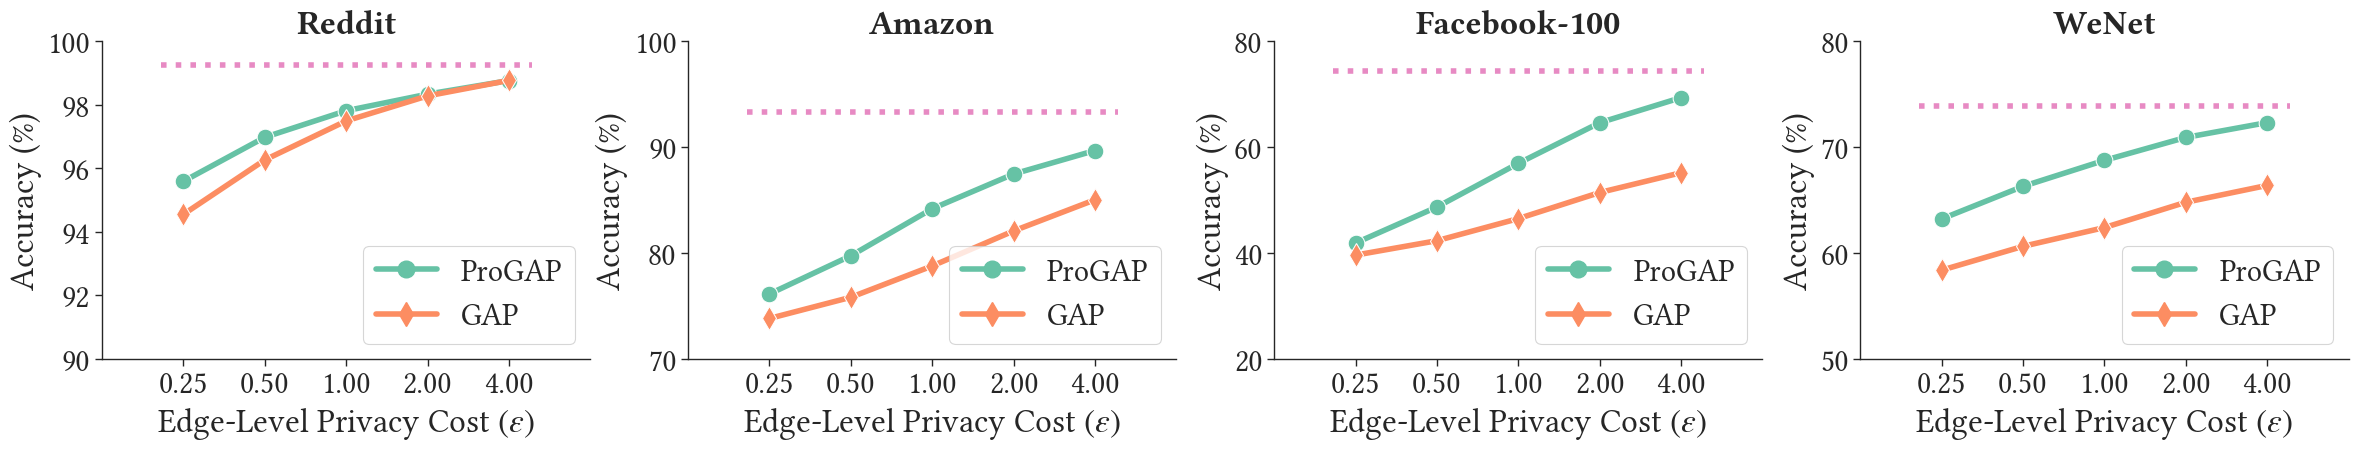

In [19]:
cols = ['id', 'method', 'level', 'dataset', 'epsilon', 'layerwise', 'repeats', 'val/acc_mean', 'test/acc_mean']
methods = ['ProGAP', 'GAP']
levels = ['edge']
datasets = ['reddit', 'amazon', 'facebook-100', 'wenet']
epsilons = [0.25, 0.5, 1, 2, 4]
eps_inf = epsilons + [np.inf]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df.loc[df['level'] == 'none', 'epsilon'] = np.inf
df = df.query('dataset in @datasets and method in @methods')
df = df.query('level in @levels or (method == "ProGAP" and level == "none")')
df = df.query('epsilon in @eps_inf')
df = df.query('not method.str.startswith("ProGAP") or layerwise == False')
df = df.query('repeats == 10')

# select best models based on valication accuracy
idx = df.groupby(['dataset', 'method', 'level', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

inf_acc = df.query('method == "ProGAP" and level == "none"')['dataset', 'test/acc_mean'].set_index('dataset')
df = df.query('level in @levels')
df = df.sort_values(by='method')

# plot
g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='method', col='dataset', aspect=1.2,
                markers=['o', 'd'], dashes=False, style='method',
                hue_order=methods, col_order=datasets, style_order=methods,
                facet_kws={'sharey': False, 'sharex': False})

g.set(ylabel='Accuracy (%)', xlabel='Edge-Level Privacy Cost $(\epsilon)$', xscale='log', xticks=epsilons, xlim=(epsilons[0] / 2, epsilons[-1] * 2))

for dataset, ax in zip(datasets, g.axes[0]):
    ax.axhline(inf_acc.loc[dataset].item(), linestyle='dotted', color=palette[3], xmin=0.12, xmax=0.88)
    # ax.axhline(mlp_acc.loc[dataset].item(), linestyle='dashed', label='MLP', color=palette[2], xmin=0.12, xmax=0.88)
    ax.set_title(label='WeNet' if dataset == 'wenet' else dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.legend.remove()
for ax in g.axes[0]:    
    ax.legend(
        loc='lower right', ncol=1, #bbox_to_anchor=(.6, 1.4), 
        handles=[legend_data[method] for method in methods], 
        labels=methods,
    )
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
g.axes[0][0].set_ylim(90, 100)
g.axes[0][1].set_ylim(70, 100)
g.axes[0][2].set_ylim(20, 80)
g.axes[0][3].set_ylim(50, 80)
# g.fig.set_figwidth(16)
g.savefig('figs/tradeoff-edge.pdf')

## Node-level DP

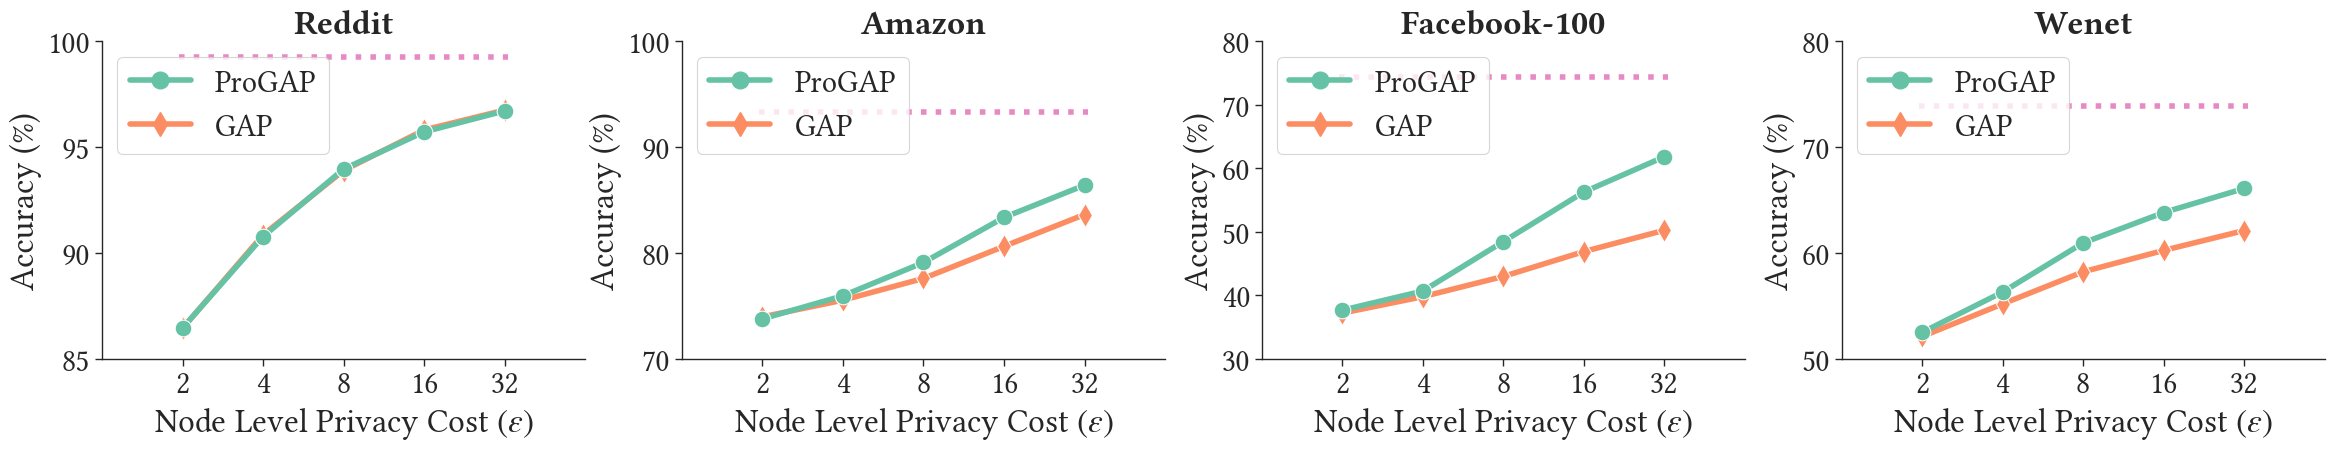

In [20]:
cols = ['id', 'method', 'level', 'dataset', 'epsilon', 'layerwise', 'repeats', 'train/acc_mean', 'val/acc_mean', 'test/acc_mean']
methods = ['ProGAP', 'GAP']
levels = ['node']
datasets = datasets = ['reddit', 'amazon', 'facebook-100', 'wenet']
epsilons = [2, 4, 8, 16, 32]
eps_inf = epsilons + [np.inf]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df.loc[df['level'] == 'none', 'epsilon'] = np.inf
df = df.query('dataset in @datasets and method in @methods')
df = df.query('level in @levels or (method == "ProGAP" and level == "none")')
df = df.query('epsilon in @eps_inf')
df = df.query('not method.str.startswith("ProGAP") or layerwise == False')
df = df.query('repeats == 10')

# select best models based on valication accuracy
idx = df.groupby(['dataset', 'method', 'level', 'epsilon'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

inf_acc = df.query('method == "ProGAP" and level == "none"')['dataset', 'test/acc_mean'].set_index('dataset')
df = df.query('level in @levels')
df = df.sort_values(by='method')
df['epsilon'] = df['epsilon'].astype(int)

# plot
# palette = sns.color_palette()
g = sns.relplot(kind='line', data=df, x='epsilon', y='test/acc_mean', hue='method', col='dataset', aspect=1.2,
                markers=['d', 'o'], dashes=False, style='method',
                hue_order=methods, col_order=datasets, style_order=methods,
                palette=[palette[1], palette[0]],
                facet_kws={'sharey': False, 'sharex': False})

g.set(ylabel='Accuracy (%)', xlabel='Node Level Privacy Cost $(\epsilon)$', xscale='log', xticks=epsilons, xlim=(epsilons[0] / 2, epsilons[-1] * 2))

for dataset, ax in zip(datasets, g.axes[0]):
    ax.axhline(inf_acc.loc[dataset].item(), linestyle='dotted', label='Non-Private', color=sns.color_palette('Set2')[3], xmin=0.16, xmax=0.84)
    ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.legend.remove()
for ax in g.axes[0]:    
    ax.legend(
        loc='upper left', ncol=1, #bbox_to_anchor=(.6, 1.4), 
        handles=[legend_data[method] for method in methods[::-1]], 
        labels=methods[::-1],
    )
g.axes[0][0].set_ylim(85, 100)
g.axes[0][1].set_ylim(70, 100)
g.axes[0][2].set_ylim(30, 80)
g.axes[0][3].set_ylim(50, 80)
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
# g.fig.set_figwidth(16)
g.savefig('figs/tradeoff-node.pdf')

# Effect of the model depth

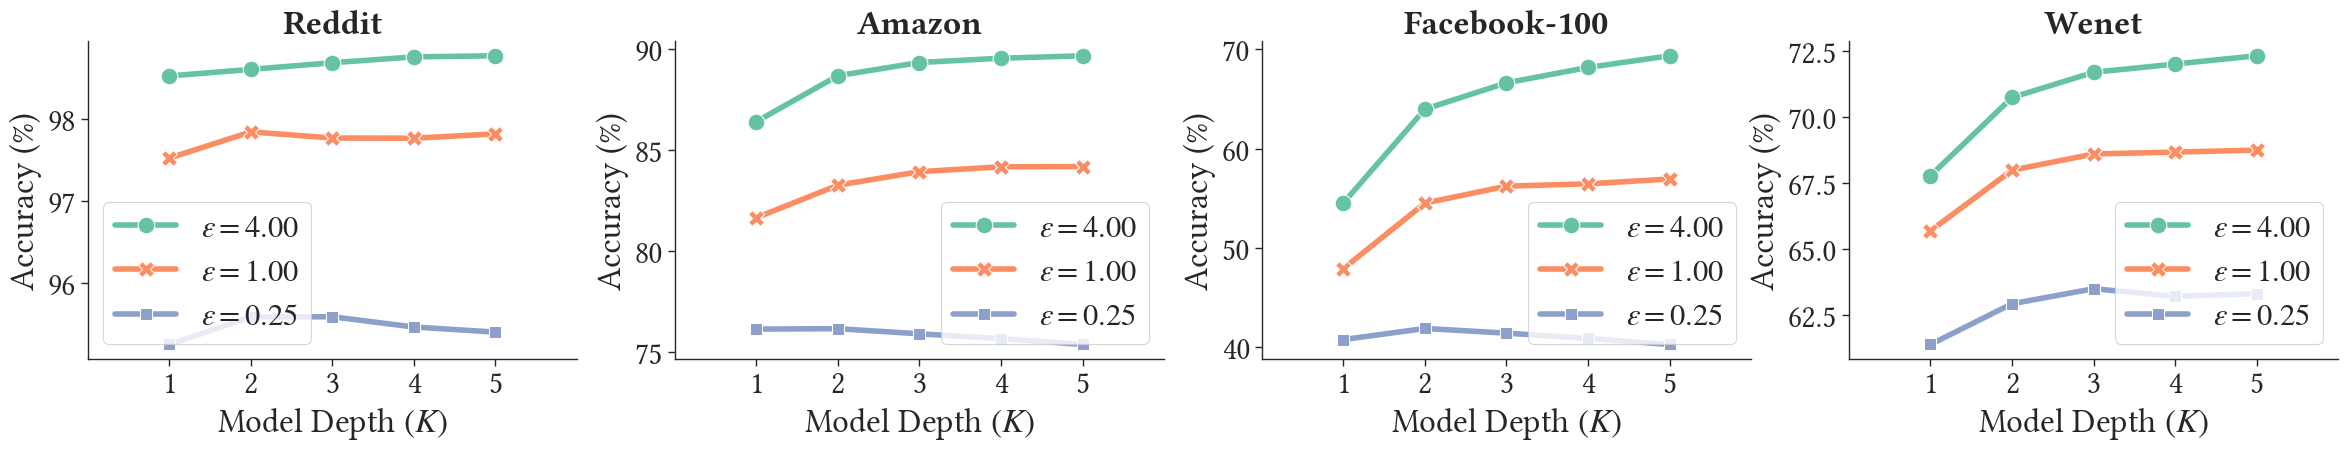

In [21]:
cols = ['method', 'level', 'dataset', 'epsilon', 'depth', 'layerwise', 'repeats', 'val/acc_mean', 'test/acc_mean']
methods = ['ProGAP']
levels = ['edge']
datasets = ['reddit', 'amazon', 'facebook-100', 'wenet']
epsilons = [0.25, 1, 4]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df.query('dataset in @datasets')
df = df.query('method in @methods')
df = df.query('level in @levels')
df = df.query('epsilon in @epsilons')
df = df.query('layerwise == False')
df = df.query('repeats == 10')

# select best models based on valication accuracy
idx = df.groupby(['method', 'level', 'dataset', 'epsilon', 'depth'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df = df.sort_values(by='epsilon', ascending=False)
df['style'] = df['method'].str.cat(df['epsilon'].astype(str), sep='-')

g = sns.relplot(kind='line', data=df, hue='style', y='test/acc_mean', x='depth', col='dataset', aspect=1.2,
                col_order=datasets, row_order=methods, markers=True, dashes=False, style='style', legend=False,
                facet_kws={'sharey': False, 'sharex': False}, errorbar=None)

g.set(ylabel='Accuracy (%)', xlabel='Model Depth $(K)$', xlim=(0,6), xticks=range(1,6))
for method, axes in zip(methods, g.axes):
    for dataset, ax in zip(datasets, axes):
        ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
        ax.legend(
            labels=[f'$\epsilon={eps:.2f}$' for eps in df.loc[(df['method'] == method) & (df['dataset'] == dataset), 'epsilon'].unique()],
        )

g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
# g.fig.set_figwidth(14)
g.savefig('figs/depth-edge.pdf')

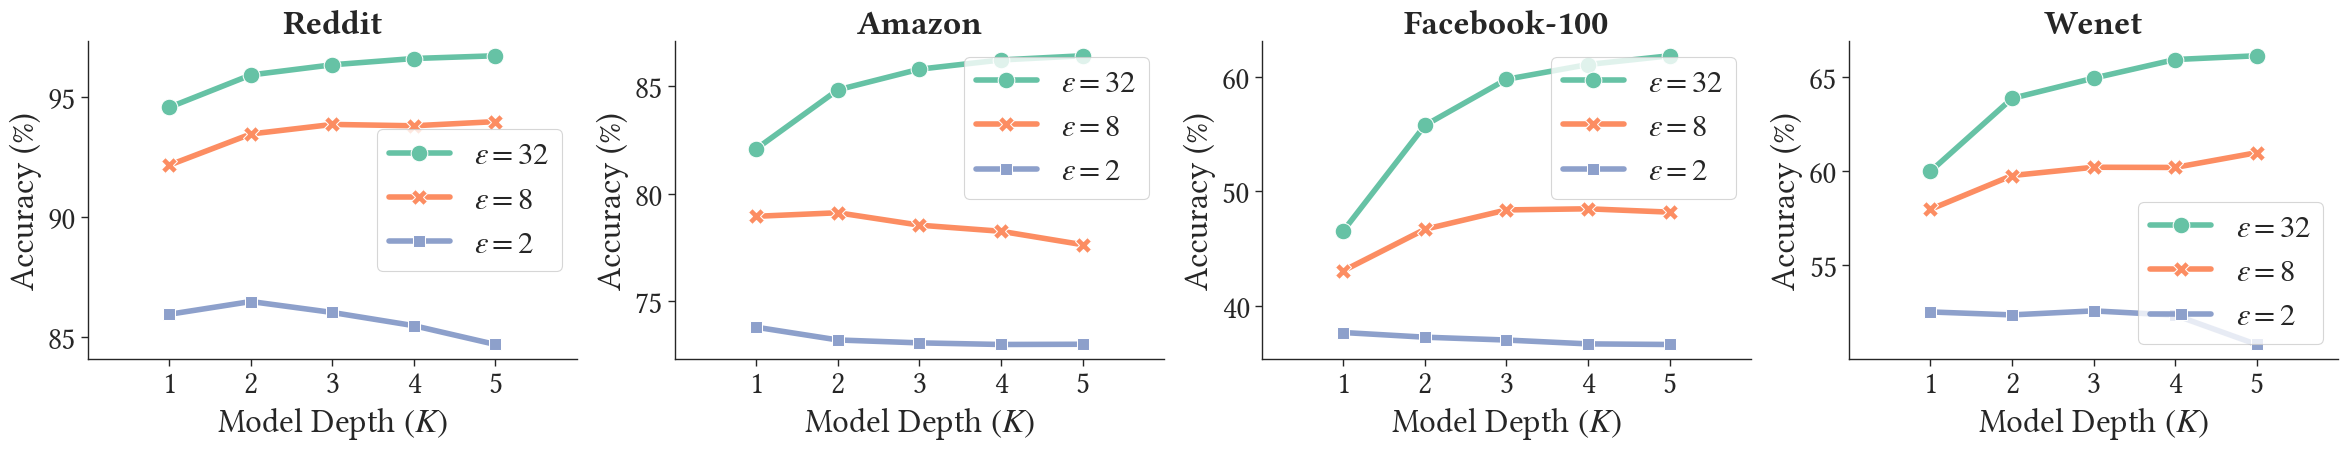

In [22]:
cols = ['method', 'level', 'dataset', 'epsilon', 'stages', 'layerwise', 'repeats', 'val/acc_mean', 'test/acc_mean']
methods = ['ProGAP']
levels = ['node']
datasets = ['reddit', 'amazon', 'facebook-100', 'wenet']
epsilons = [2, 8, 32]

# filter data
df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df.query('dataset in @datasets')
df = df.query('method in @methods')
df = df.query('level in @levels')
df = df.query('epsilon in @epsilons')
df = df.query('layerwise == False')
df = df.query('repeats == 10')

# select best models based on valication accuracy
idx = df.groupby(['method', 'level', 'dataset', 'epsilon', 'depth'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df = df.sort_values(by='epsilon', ascending=False)
df['style'] = df['method'].str.cat(df['epsilon'].astype(str), sep='-')

g = sns.relplot(kind='line', data=df, hue='style', y='test/acc_mean', x='depth', col='dataset', aspect=1.2,
                col_order=datasets, row_order=methods, markers=True, dashes=False, style='style', legend=False,
                facet_kws={'sharey': False, 'sharex': False}, errorbar=None)

g.set(ylabel='Accuracy (%)', xlabel='Model Depth $(K)$', xlim=(0,6), xticks=range(1,6))
for method, axes in zip(methods, g.axes):
    for dataset, ax in zip(datasets, axes):
        ax.set_title(label=dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
        ax.legend(
            labels=[f'$\epsilon={eps:.2f}$' for eps in df.loc[(df['method'] == method) & (df['dataset'] == dataset), 'epsilon'].unique()],
        )


g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
# g.fig.set_figwidth(14)
g.savefig('figs/depth-node.pdf')
# df

# Convergence Analysis

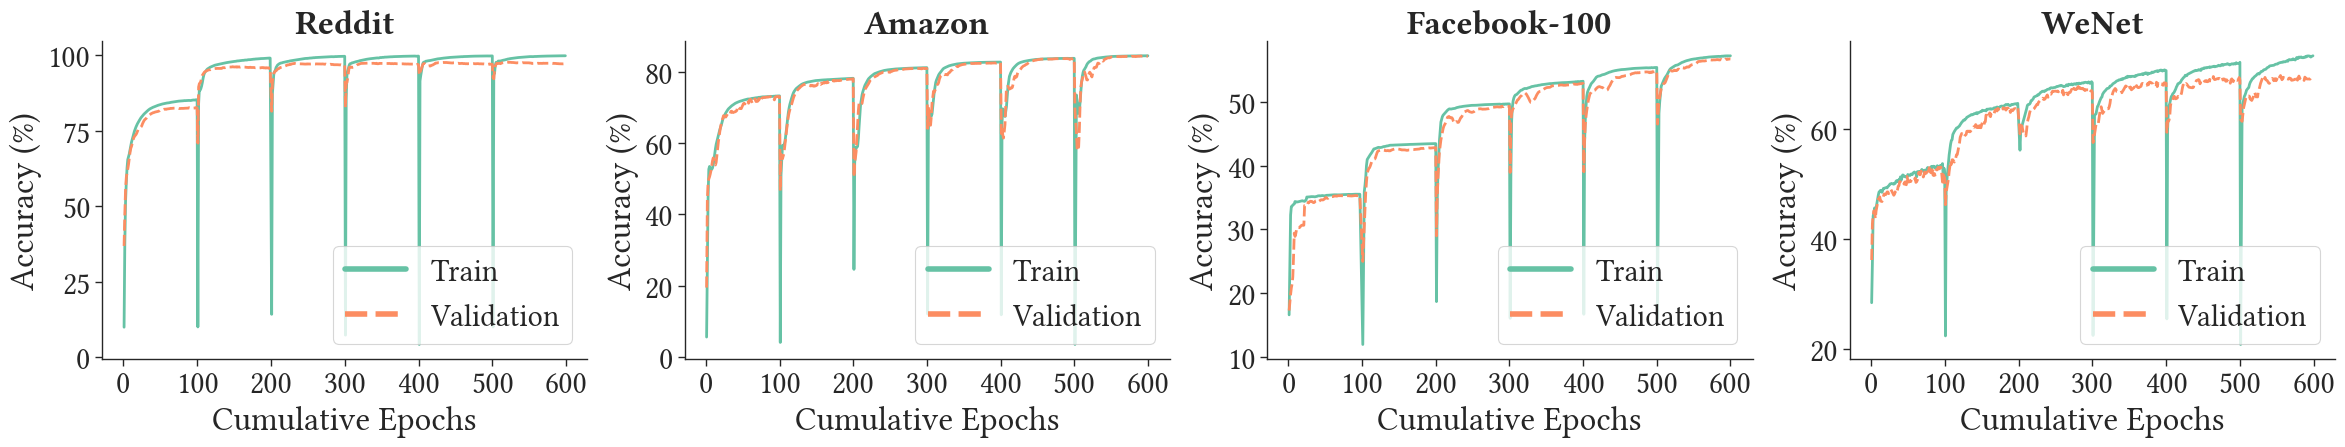

In [14]:
cols = ['id', 'method', 'level', 'dataset', 'train/acc_mean', 'val/acc_mean', 'layerwise', 'log_all']
methods = ['ProGAP']
levels = ['edge']
datasets = ['reddit', 'amazon', 'facebook-100', 'wenet']

df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df.query('dataset in @datasets and method in @methods and level in @levels and layerwise == False and log_all == True')
df = df.dropna()
idx = df.groupby(['dataset', 'method', 'level'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df_history = pd.DataFrame()
for i, row in df.iterrows():
    df_run_history = row.run.history().filter(items=['_step', 'train/acc', 'val/acc'])
    df_run_history['_step'] += 1
    df_run_history['method'] = row.method
    df_run_history['level'] = row.level
    df_run_history['dataset'] = row.dataset
    df_history = pd.concat([df_history, df_run_history], ignore_index=True)

df_history = df_history.melt(
    id_vars=['_step', 'method', 'level', 'dataset'],
    value_vars=['train/acc', 'val/acc'],
    var_name='metric',
)

df_history['metric'] = df_history['metric'].replace({
    'train/acc': 'Train',
    'val/acc': 'Validation',
})

g = sns.relplot(kind='line', data=df_history, x='_step', y='value', hue='metric', col='dataset', aspect=1.2,
                col_order=datasets, markers=False, dashes=True, style='metric',
                facet_kws={'sharey': False, 'sharex': False}, errorbar=None, linewidth=2)

g.set(ylabel='Accuracy (%)', xlabel='Cumulative Epochs', xticks=range(0,601,100))

for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label='WeNet' if dataset == 'wenet' else dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.legend.remove()
for ax in g.axes[0]:    
    ax.legend(
        loc='lower right', ncol=1, #bbox_to_anchor=(.6, 1.4), 
        handles=legend_data.values(), labels=legend_data.keys(),
    )
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
# g.fig.set_figwidth(16)
g.savefig('figs/convergence-edge.pdf')

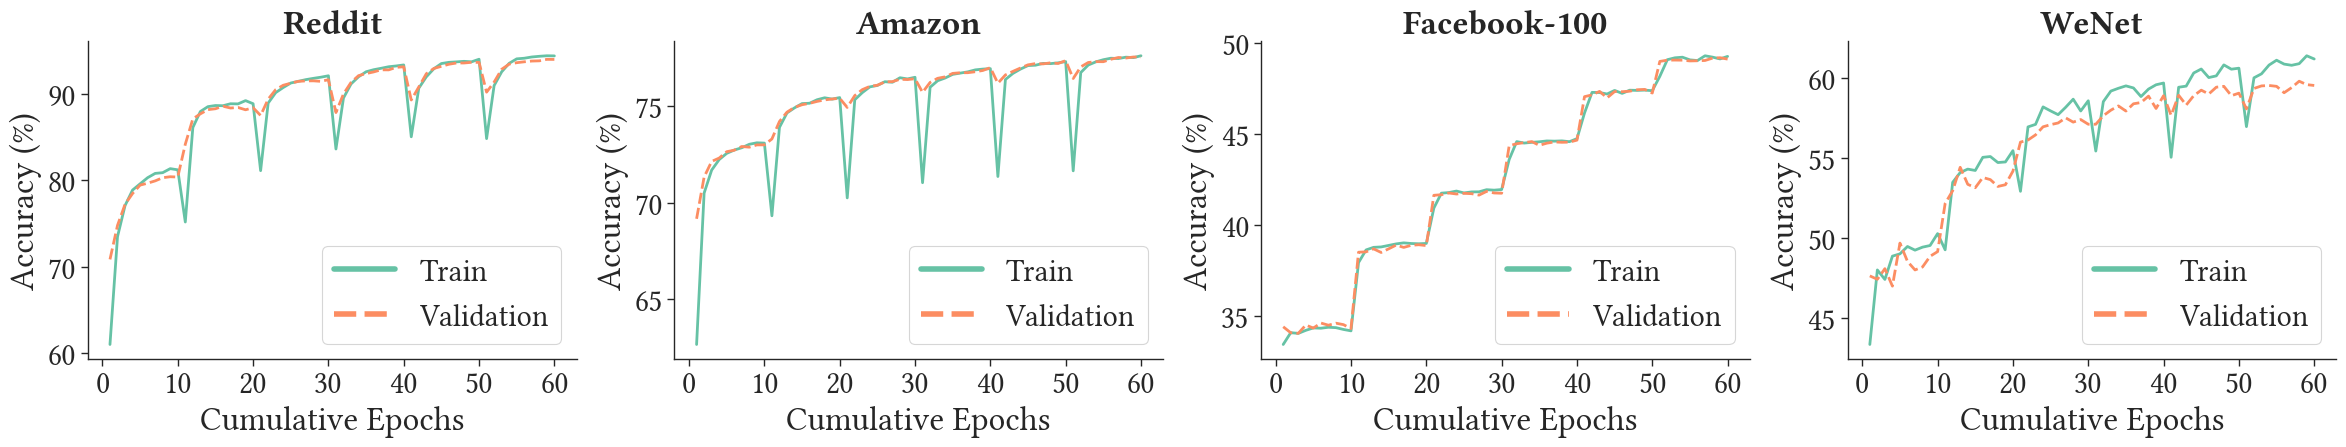

In [15]:
cols = ['id', 'method', 'level', 'dataset', 'train/acc_mean', 'val/acc_mean', 'layerwise', 'log_all']
methods = ['ProGAP']
levels = ['node']
datasets = ['reddit', 'amazon', 'facebook-100', 'wenet']

df = pd.DataFrame(data_list)
df = df.filter(items=cols)
df = df.query('dataset in @datasets and method in @methods and level in @levels and layerwise == False and log_all == True')
df = df.dropna()
idx = df.groupby(['dataset', 'method', 'level'])['val/acc_mean'].idxmax().values
df = df.loc[idx]

df_history = pd.DataFrame()
for i, row in df.iterrows():
    df_run_history = row.run.history().filter(items=['_step', 'train/acc', 'val/acc'])
    df_run_history['_step'] += 1
    df_run_history['method'] = row.method
    df_run_history['level'] = row.level
    df_run_history['dataset'] = row.dataset
    df_history = pd.concat([df_history, df_run_history], ignore_index=True)

df_history = df_history.melt(
    id_vars=['_step', 'method', 'level', 'dataset'],
    value_vars=['train/acc', 'val/acc'],
    var_name='metric',
)

df_history['metric'] = df_history['metric'].replace({
    'train/acc': 'Train',
    'val/acc': 'Validation',
})

g = sns.relplot(kind='line', data=df_history, x='_step', y='value', hue='metric', col='dataset', aspect=1.2,
                col_order=datasets, markers=False, dashes=True, style='metric',
                facet_kws={'sharey': False, 'sharex': False}, errorbar=None, linewidth=2)

g.set(ylabel='Accuracy (%)', xlabel='Cumulative Epochs', xticks=range(0,601,100))

for dataset, ax in zip(datasets, g.axes[0]):
    ax.set_title(label='WeNet' if dataset == 'wenet' else dataset.capitalize(), fontdict={'fontweight': 'bold'}, )
    ax.get_xaxis().set_major_formatter(ScalarFormatter())
    ax.minorticks_off()

handles, labels = g.axes[0][0].get_legend_handles_labels()
legend_data = {label: handle for label, handle in zip(labels, handles)}
g.legend.remove()
for ax in g.axes[0]:    
    ax.legend(
        loc='lower right', ncol=1, #bbox_to_anchor=(.6, 1.4), 
        handles=legend_data.values(), labels=legend_data.keys(),
    )
g.fig.subplots_adjust(hspace=0.4, wspace=0.2)
# g.fig.set_figwidth(16)
g.savefig('figs/convergence-node.pdf')